<a href="https://colab.research.google.com/github/helloitsdaksh/Project_DSCI599-531/blob/main/DSCI_531_599_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.1 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import xgboost as xgb
from sklearn.preprocessing import TargetEncoder
import optuna
import os
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from datetime import datetime

In [17]:
FEMALE_POP = 0.536
FEMALE_CAMPAIGN_POP = 0.392619
MALE_POP = 0.464
MALE_CAMPAIGN_POP = 0.607381
FEMALE_RATIO = FEMALE_POP / FEMALE_CAMPAIGN_POP
MALE_RATIO = MALE_POP / MALE_CAMPAIGN_POP

In [2]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


--------------------------------------------------------------
# Data utilities
--------------------------------------------------------------

In [18]:
import numpy as np
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score

def load_data(
		nrows: int = None,
		filename: str = "fairjob.csv.gz"
		):
	"""
	Data loader for FairJob dataset.

	Args:
		nrows (int): How many rows to load for np.loadtxt. Defaults to None.
		filename (str): Name of data file located in data/. Defaults to "fairjob.csv.gz".

	Returns:
		X (numpy.ndarray): (n_data, n_features)
		click (np.ndarray): (n_data,)
		protected_attribute (numpy.ndarray): (n_data,)
		senior (numpy.ndarray): (n_data,)
		displayrandom (numpy.ndarray): (n_data,)
		rank (numpy.ndarray): (n_data,)
		categorical_features_cardinalities (dict): categorical features cardinalities
	"""

	data = np.loadtxt((filename), skiprows=1, delimiter=",", max_rows=nrows)
	click_idx = 0
	protected_attribute_idx = 1
	senior_idx = 2
	displayrandom_idx = 3
	rank_idx = 4
	X = data[:, 5:]
	n_cat_cols = np.sum(X.mean(axis=0) > 1e-1)
	categorical_features_idx = np.arange(0, n_cat_cols)
	categorical_features_cardinalities = dict()

	# counting unique tokens per categorical variable
	# and renumbering them from 0
	for dim in range(len(categorical_features_idx)):
		renumber_dict = dict()
		values = np.unique(X[:, dim])
		categorical_features_cardinalities[dim] = len(values)
		for i, v in enumerate(values):
			renumber_dict[v] = i
		for i in range(len(X)):
			X[i, dim] = renumber_dict[X[i, dim]]

	return (
		X,
		data[:, click_idx],
		data[:, protected_attribute_idx],
		data[:, senior_idx],
		data[:, displayrandom_idx],
		data[:, rank_idx],
		categorical_features_cardinalities,
		)

class JobDataset(Dataset):
	"""
	Class collecting the variables of the data necessary for batch generation.
	"""

	def __init__(self, X, y, protected_attribute, fair_indicator):
		self.X = X
		self.y = y
		self.protected_attribute = protected_attribute
		if fair_indicator is None:
			self.fair_indicator = torch.ones_like(y).to(torch.int).to(y.device)
		else:
			self.fair_indicator = fair_indicator

	def __len__(self):
		return len(self.y)

	def get_target(self):
		return self.y

	def __getitem__(self, idx):
		return self.X[idx], self.y[idx], self.protected_attribute[idx], self.fair_indicator[idx]

def batch_loader(dataset: JobDataset, batch_size: int):
	"""
	Factory for batch data loader with weighted random sampling for addressing class imbalance.

	Args:
		dataset (JobDataset): Training data
		batch_size (int): Batch size

	Returns:
		DataLoader
	"""

	class_counts = torch.bincount(dataset.get_target())
	class_weights = 1.0 / class_counts.float()
	# Create weights for each sample in the dataset
	sample_weights = class_weights[dataset.get_target()]
	sample_weights = sample_weights.detach().cpu().numpy()

	sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
	return DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)


def train_test_split(
		X, y, protected_attribute, is_senior, displayrandom, rank, train_fraction: float = 0.8
		):
	"""
	Random split of data in training and test sets.

	Args:
		X: Features
		y: Target labels
		protected_attribute: Protected attribute
		is_senior: Flag for senior ads.
		displayrandom: Flag for ads with random display order in the banner.
		rank: Ads rank in the banner.
		train_fraction (float): Fraction for training data. Defaults to 0.8.

	Returns:
		X_train,
		X_test,
		y_train,
		y_test,
		protected_attribute_train,
		protected_attribute_test,
		is_senior_train,
		is_senior_test,
		displayrandom_train,
		displayrandom_test
		rank_train,
		rank_test
	"""

	cut = int(len(X) * train_fraction * 100 // 100)
	X_train = X[:cut, :]
	X_test = X[cut:, :]
	y_train = y[:cut]
	y_test = y[cut:]
	protected_attribute_train = protected_attribute[:cut]
	protected_attribute_test = protected_attribute[cut:]
	is_senior_train = is_senior[:cut]
	is_senior_test = is_senior[cut:]
	displayrandom_train = displayrandom[:cut]
	displayrandom_test = displayrandom[cut:]
	rank_train = rank[:cut]
	rank_test = rank[cut:]
	return (
		X_train,
		X_test,
		y_train,
		y_test,
		protected_attribute_train,
		protected_attribute_test,
		is_senior_train,
		is_senior_test,
		displayrandom_train,
		displayrandom_test,
		rank_train,
		rank_test,
		)

--------------------------------------------------------------
# Models
--------------------------------------------------------------

In [19]:
class DummyClassifier(nn.Module):
	"""
	Classifier based on single threshold for positive class probability.
	"""

	def __init__(self, start_p: float = 0.005):
		super().__init__()
		self.bias = nn.Parameter(Tensor([1 - start_p, start_p]))
		self.bias.requires_grad = True
		self.register_buffer("zero_const", torch.zeros((1, 2)))

	def forward(self, x):
		return self.zero_const.repeat(x.shape[0], 1) + self.bias

	def __str__(self):
		return "Dummy"


class MixedEmbedding(nn.Module):
	"""
	Layer for embedding categorical and continuous features for Logistic Regression.
	"""

	def __init__(
			self,
			input_dim: int,
			categorical_features_cardinalities: dict,
			embedding_size: int = 10,
			):
		"""
		Args:
			input_dim (int): dimension of input features
			categorical_features_cardinalities (dict): cardinalities (values) for each categorical feature (column index in the data as key)
			embedding_size (int): Output size of the mixed embedding layer. Defaults to 10.
		"""
		super().__init__()
		self.input_dim = input_dim
		self.embedding_size = embedding_size
		self.categorical_features_idx = np.array(
			[_ for _ in categorical_features_cardinalities.keys()]
			)
		self.numerical_features_idx = np.array(
			[_ for _ in range(input_dim) if _ not in self.categorical_features_idx]
			)
		self.embeddings = nn.ModuleList(
			[
				nn.Embedding(
					num_embeddings=categorical_features_cardinalities[cat_feature_idx],
					embedding_dim=min(
						embedding_size,
						categorical_features_cardinalities[cat_feature_idx],
						),
					)
				for cat_feature_idx in self.categorical_features_idx
				]
			)
		self.output_dimension = len(self.numerical_features_idx) + sum(
			[e.embedding_dim for e in self.embeddings]
			)

	def forward(self, x):
		catx = x[:, self.categorical_features_idx].int()
		numx = x[:, self.numerical_features_idx]
		embeddedx = torch.hstack(
			[self.embeddings[_](catx[:, _]) for _ in self.categorical_features_idx]
			)
		embeddedx = embeddedx.view(-1, self.output_dimension - len(self.numerical_features_idx))
		return torch.hstack([embeddedx, numx])

	def to(self, device):
		self.embeddings.to(device)


class LogisticRegression(nn.Module):
	"""
	Logistic regression classifier.
	"""

	def __init__(
			self,
			input_dim: int,
			categorical_features_cardinalities: dict,
			embedding_size: int,
			):
		"""
		Args:
			input_dim (int): dimension of input features
			categorical_features_cardinalities (dict): cardinalities (values) for each categorical feature (column index in the data as key)
			embedding_size (int): Output size of the mixed embedding layer.
		"""
		super().__init__()
		self.mixed_embedding_layer = MixedEmbedding(
			input_dim,
			categorical_features_cardinalities,
			embedding_size=embedding_size,
			)
		self.weights = nn.Linear(
			in_features=self.mixed_embedding_layer.output_dimension, out_features=2
			)

	def forward(self, x):
		xx = self.mixed_embedding_layer(x)
		return self.weights(xx)

	def __str__(self):
		return "LR"

	def to(self, device):
		self.mixed_embedding_layer.to(device)
		self.weights.to(device)

--------------------------------------------------------------------------------
# Learning routines
--------------------------------------------------------------------------------


In [20]:

def l2_conditional_independence_penalty(
		y_hat: Tensor, y_true: Tensor, protected_attribute: Tensor, fair_indicator: Tensor, *kwars
		):
	"""
	Implementation of the fairness penalty based on Bechavod & Ligett - https://arxiv.org/abs/1707.00044.
	Differently from the original proposal, it uses the squared discrepancies between
	the unconditional values of FPR, FNR, TPR, TNR and their conditional values, for both protected attribute labels.

	Args:
		y_hat (Tensor): Predicted probabilities for the two target labels. Dimensions: (n_data, 2)
		y_true (Tensor): True labels. Dimensions: (n_data,)
		protected_attribute (Tensor): Protected attributed values. Dimensions: (n_data,)
		fair_indicator (Tensor): Indicator for observations to be included in the penalty computation. Dimensions: (n_data,)

	Returns:
		Value of the fairness penalty
	"""

	assert y_hat.shape[1] == 2
	sum_of_squares = Tensor([0.0]).to(y_hat.device)

	y_hat = y_hat[fair_indicator, :]
	y_true = y_true[fair_indicator]
	protected_attribute = protected_attribute[fair_indicator]
	for y_hat_dim in (0, 1):
		y_hat_col = y_hat[:, y_hat_dim]
		for y_dim in (0, 1):
			if torch.sum(y_true == y_dim) == 0.0:  # no such label
				continue
			y_hat_avg = torch.mean(y_hat_col[y_true == y_dim])
			for a_dim in (0, 1):
				if (
						torch.sum((y_true == y_dim) & (protected_attribute == a_dim)) == 0.0
				):  # no such label given attribute
					y_hat_cond_a_avg = torch.tensor(0.0)
				else:
					y_hat_cond_a_avg = torch.mean(
						y_hat_col[(y_true == y_dim) & (protected_attribute == a_dim)]
						)
				sum_of_squares += (y_hat_avg - y_hat_cond_a_avg) ** 2
	penalty = torch.sqrt(sum_of_squares)[0]
	return penalty


class Learner(object):
	"""
	General class for learner.
	"""

	def __init__(
			self,
			base_model,
			device="cuda",
			basename: str = "REGULAR",
			scheduler_step_size=30,
			scheduler_gamma=0.1,
			**optimizer_options
			):
		"""
		Args:
			base_model: Base model class  (e.g., Dummy, LogisticRegression)
			device (str): Device for PyTorch. Defaults to "cuda".
			basename (str): Model name. Defaults to "REGULAR".
			scheduler_step_size (int): Step size parameter for learning rate scheduler. Defaults to 30.
			scheduler_gamma (float): Gamma parameter for learning rate scheduler. Defaults to 0.1.
		"""

		self.model = base_model
		self.model.ps_init = nn.Parameter(torch.randn(1), requires_grad=False)
		self.model.ps = nn.Parameter(self.model.ps_init.data, requires_grad=True)
		self.basename = basename
		self.loss = nn.CrossEntropyLoss()
		self.optimizer = torch.optim.Adam(self.model.parameters(), **optimizer_options)
		self.scheduler = torch.optim.lr_scheduler.StepLR(
			self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
			)
		self.device = device
		self.model.to(device)

	def __str__(self):
		return self.basename + " " + str(self.model).split("(")[0]

	def fit(
			self,
			x: Tensor,
			y: Tensor,
			a: Tensor,
			batch_size=1024,
			penalty_fun=None,
			penalty_multiplier: float = 0.1,
			fair_indicator: Tensor = None,
			):
		"""
		Fit function (single epoch).

		Args:
			x (Tensor): Training features
			y (Tensor): Training target labels
			a (Tensor): Training protected attribute
			batch_size (int): Batch size. Defaults to 1024.
			penalty_fun : Additional penalty function to include fairness penalty. Defaults to None.
			penalty_multiplier (float): Multiplier for additional penalty function. Defaults to 0.1.
			fair_indicator (Tensor):  Indicator for observations to be included in the penalty computation. Defaults to None.

		Returns:
			Loss value
		"""

		loss_value = 0

		data_train = JobDataset(x, y, a, fair_indicator)
		for batch in batch_loader(data_train, batch_size=batch_size):
			x_b, y_b, a_b, fair_indicator_b = batch
			o_b = x_b[:, 1]
			self.optimizer.zero_grad()
			outputs_b = self.model(x_b)

			loss_b = self.loss(outputs_b, y_b)

			if penalty_fun is not None:
				probas_b = torch.softmax(outputs_b, dim=1)
				assert torch.max(probas_b) <= 1.0, torch.max(probas_b)
				assert torch.min(probas_b) >= 0.0, torch.min(probas_b)
				loss_b += penalty_multiplier * penalty_fun(
					y_hat=probas_b,
					y_true=y_b,
					protected_attribute=a_b,
					fair_indicator=fair_indicator_b,
					)

			loss_b.backward()
			loss_value += loss_b.detach().cpu().numpy()
			self.optimizer.step()

		return loss_value

	def scheduler_step(self):
		self.scheduler.step()

	def __call__(self, *args, **kwargs):
		return self.model(*args, **kwargs)

	def get_ps(self, *args, **kwargs):
		return self.model.ps.data

	def get_ps_init(self, *args, **kwargs):
		return self.model.ps_init.data

	def to(self, device: str):
		self.device = device
		self.model.to(device)
		self.loss.to(device)


--------------------------------------------------------------------------------
# Metrics
--------------------------------------------------------------------------------

In [21]:

def demographic_parity(predictions, protected_attribute, scope):
	"""
	Function to compute demographic parity with respect to scope.

	Args:
		predictions: model predictions
		protected_attribute: protected attribute values
		scope: indicator for scope

	Returns:
	   Demographic parity
	"""

	res = 0.0
	for col in (0, 1):
		res += torch.abs(
			torch.mean(predictions[(protected_attribute > 0) & (scope > 0)][:, col])
			- torch.mean(predictions[(protected_attribute <= 0) & (scope > 0)][:, col])
			)
	return res / 2.0


def utility(
		y_pred: Tensor,
		y: Tensor,
		protected_attribute: Tensor,
		impressions: Tensor,
		displayrandom: Tensor,
		):
	"""
	Click utility function.

	Args:
		y_pred (Tensor): Predicted probabilities for the two target labels. Dimensions (n_data, 2)
		y (Tensor): Target labels. Dimensions (n_data,)
		protected_attribute (Tensor): Protected attribute. Dimensions (n_data,)
		impressions (Tensor): Impression_id. Dimensions (n_data,)
		displayrandom (Tensor): Flag for ads with random display order in the banner. Dimensions (n_data,)

	Returns:
		Value of the utility
	"""

	# Higher is better
	res = 0.0
	click_col = 1
	# Subselect only data with randomized display
	mask = (displayrandom > 0)
	y_pred = y_pred[mask]
	y = y[mask]
	protected_attribute = protected_attribute[mask]
	impressions = impressions[mask]

	for impression in torch.unique(impressions):
		y_ranked = (torch.argsort(y_pred[impressions == impression,click_col]) + 1).to(torch.float)
		y_clicked = y[impressions == impression]
		click_rank_impression = torch.mean(y_ranked * y_clicked)

		res += click_rank_impression

	return res / (torch.unique(impressions)).size(dim=0)


def utility_product(
		y_pred, y, protected_attribute, impressions, displayrandom, product, unbiased_ratio=False
		):
	"""
	Product utility function.

	Args:
		y_pred (Tensor): Predicted probabilities for the two target labels. Dimensions (n_data, 2)
		y (Tensor): Target labels. Dimensions (n_data,)
		protected_attribute (Tensor): Protected attribute. Dimensions (n_data,)
		impressions (Tensor): Impression_id. Dimensions (n_data,)
		displayrandom (Tensor): Flag for ads with random display order in the banner. Dimensions (n_data,)
		unbiased_ratio (bool): True if the utility should be corrected with the data-population ratio of the protected attribute. Defaults to False.

	Returns:
		Value of the utility
	"""

	res = 0.0
	click_col = 1
	# Subselect only data with randomized display
	mask = (displayrandom > 0)
	y_pred = y_pred[mask]
	y = y[mask]
	protected_attribute = protected_attribute[mask]
	impressions = impressions[mask]
	product = product[mask]

	# Create rank probs for each impression
	y_ranked = torch.zeros_like(y,dtype=torch.float)
	for impression in torch.unique(impressions):
		y_ranked[impressions == impression] = (torch.argsort(y_pred[impressions == impression,click_col]) + 1).to(torch.float)

	if unbiased_ratio:
		ratio = (protected_attribute == 0) * FEMALE_RATIO + \
				(protected_attribute == 1) * MALE_RATIO
	else:
		ratio = torch.ones_like(protected_attribute, dtype=torch.float)

	for prod in torch.unique(product):
		prod_mask = (product == prod)
		for impression in torch.unique(impressions[prod_mask]):
			size_impressions_prod = torch.unique(impressions[prod_mask]).shape[0]
			impression_prod_mask = (impressions == impression) & prod_mask # Not really necessary, each impression is for a specific product
			y_ranked_prod = y_ranked[impression_prod_mask]
			y_clicked_prod = y[impression_prod_mask]

			click_rank_impression = (y_ranked_prod * ratio[impression_prod_mask]).dot(y_clicked_prod.to(torch.float))
			res += click_rank_impression/size_impressions_prod

	return res/ torch.unique(product).shape[0]


def evaluate(
		res_pred_df: pd.DataFrame,
		results_df: pd.DataFrame,
		name: str,
		l2_fair: float,
		fair_frac: float,
		sim: int,
		model,
		X_test: Tensor,
		y_test: Tensor,
		protected_attribute_test: Tensor,
		is_senior_test: Tensor,
		impression_test: Tensor,
		displayrandom_test: Tensor,
		product_test: Tensor,
		):
	"""
	Function for computing model evaluation metrics and save results.

	Args:
		res_pred_df (pd.DataFrame): DataFrame for saving model predictions.
		results_df (pd.DataFrame): DataFrame for saving model metrics.
		name (str): Model name as used in DataFrame index.
		l2_fair (float): Fairness penalty multiplier. Use None if without penalty.
		fair_frac (float): Fraction of data used to compute the fairness penalty. Use None if without penalty.
		sim (int): Simulation index.
		model: Model to use for predictions.
		X_test (Tensor): Test features.
		y_test (Tensor): Test target labels.
		protected_attribute_test (Tensor): Test protected attribute.
		is_senior_test (Tensor): Test senior ads indicator.
		impression_test (Tensor): Test impression id.
		displayrandom_test (Tensor): Test displayrandom.
		product_test (Tensor): Test product id.

	Returns:
		res_pred_df: updated with new values. Note that results_df is modified in-place.
	"""

	with torch.no_grad():
		y_pred = model(X_test)
		p = torch.softmax(y_pred, dim=1)
	if l2_fair is not None:
		# We save fair models
		rows_index = (name,l2_fair,fair_frac,sim)
	else:
		# We save regular models
		rows_index = (name,sim)

	# Saving prediction
	res_pred_df = pd.concat(
		[
			res_pred_df,
			pd.DataFrame(
				{
					"prob_test": p[:,1].detach().cpu().numpy(),
					"y_test": y_test.detach().cpu().numpy(),
					"a_test": protected_attribute_test.detach().cpu().numpy(),
					"s_test": is_senior_test.detach().cpu().numpy(),
					"displayrandom_test": displayrandom_test.detach().cpu().numpy(),
					"impression_id_test": impression_test.detach().cpu().numpy(),
					"product_id_test": product_test.detach().cpu().numpy(),
					}
				).reset_index(names="obs_index").assign(model=name,
														fairness_multiplier=l2_fair,
														fairness_fraction=fair_frac,
														iteration=sim),
			]
		)

	results_df.loc[rows_index] = {
		"NLLH": nn.CrossEntropyLoss()(y_pred, y_test).item(),
		"DP": demographic_parity(p, protected_attribute_test, is_senior_test).item(),
		"UTILITY": utility(
			p, y_test, protected_attribute_test, impression_test, displayrandom_test
			).item(),
		"UTILITY_PRODUCT": utility_product(
			p, y_test, protected_attribute_test, impression_test, displayrandom_test, product_test, unbiased_ratio=False
			).item(),
		"UTILITY_PRODUCT_FAIR": utility_product(
			p, y_test, protected_attribute_test, impression_test, displayrandom_test, product_test, unbiased_ratio=True
			).item(),
		"AU-ROC": roc_auc_score(y_true=y_test.detach().cpu().numpy(),
								y_score=p[:,1].detach().cpu().numpy(),
								average='macro'),
		"AVG-P-SCORE": average_precision_score(y_true=y_test.detach().cpu().numpy(),
											   y_score=p[:,1].detach().cpu().numpy(),
											   average='macro'),
		}
	print(
		"(%20s) NLLH: %.5f DP: %.5f UTILITY: %.5f UTILITY_P: %.5f UTILITY_P_FAIR: %.5f AU-ROC: %.5f AVG-P-SCORE: %.5f"
		% (
			model,
			results_df.loc[rows_index,'NLLH'],
			results_df.loc[rows_index,'DP'],
			results_df.loc[rows_index,'UTILITY'],
			results_df.loc[rows_index,'UTILITY_PRODUCT'],
			results_df.loc[rows_index,'UTILITY_PRODUCT_FAIR'],
			results_df.loc[rows_index,'AU-ROC'],
			results_df.loc[rows_index,'AVG-P-SCORE']
			)
		)
	return res_pred_df


def prediction_stats(model, X_test: Tensor, protected_attribute_test: Tensor):
	"""
	Prints the prediction statistics with respect to protected attribute.

	Args:
		model: Model used for prediction
		X_test (Tensor): Test features.
		protected_attribute_test (_type_): Test protected attribute.
	"""

	with torch.no_grad():
		y_pred = model(X_test)
	res_fit_df = pd.DataFrame({'attribute': protected_attribute_test.detach().cpu().numpy(),
							   0: torch.softmax(y_pred,dim=1).detach().cpu().numpy()[:,0],
							   1: torch.softmax(y_pred,dim=1).detach().cpu().numpy()[:,1]})
	print(res_fit_df.set_index('attribute').groupby('attribute').mean())
	print(torch.softmax(y_pred,dim=1).detach().cpu().numpy()[0,:])
	print('\n')


--------------------------------------------------------------------------------
# Run Experiments
--------------------------------------------------------------------------------

In [22]:
def run_experiment(args):
	# Copy the main execution logic of your script int(f"Running experiment with settings: {args}")
	N_TRAIN_EXAMPLES = 10**5
	DATA_SIZE = None  # None for all data
	sim = 0
	N_EPOCHS = 50

	# Seed for reproducibility
	torch.manual_seed(43523)
	np.random.seed(43523)

	# Check for MPS (Metal Performance Shaders) on macOS
	if torch.backends.mps.is_available():
		device = torch.device("mps")  # Use Metal for PyTorch
		xgb_device = "cpu"  # XGBoost does not support MPS yet, so use CPU
		xgb_tree_method = "hist"  # Use histogram-based tree method for efficiency
	elif torch.cuda.is_available():
		device = torch.device("cuda")  # Use CUDA if available
		xgb_device = "cuda"
		xgb_tree_method = "hist"
	else:
		device = torch.device("cpu")  # Fallback to CPU
		xgb_device = "cpu"
		xgb_tree_method = "hist"

	print(f"Using device: {device}")

	if not os.path.exists(("output")):
		os.makedirs(("output"))

	if not os.path.exists(("output/model_hyperparameters")):
		os.makedirs(("output/model_hyperparameters"))


	batch_size = args.batch
	l2_fair_multiplier = args.lambda_fair
	fair_fraction = args.data_frac
	n_trials = args.ntrial

	# Print setup
	print(args)
	print('Device: ' + str(device))

	# Name for saving results
	args.name = (
			"_"
			+ args.name
			+ "_lambda"
			+ str(args.lambda_fair)
			+ "_frac"
			+ str(args.data_frac)
	)


	# DataFrame for saving results
	res_pred_df = pd.DataFrame(
		columns=[
			"model",
			"fairness_multiplier",
			"fairness_fraction",
			"obs_index",
			"prob_test",
			"y_test",
			"a_test",
			"s_test",
			"displayrandom_test",
			"impression_id_test",
			"product_id_test",
			]
		)

	# Data loading and splitting
	(
		X,
		y,
		protected_attribute,
		is_senior,
		displayrandom,
		rank,
		categorical_features_cardinalities,
		) = load_data(DATA_SIZE, args.data)

	X, y, protected_attribute, is_senior, displayrandom, rank = (
		Tensor(X.astype(np.float64)).to(device),
		Tensor(y).long().to(device),
		Tensor(protected_attribute).long().to(device),
		Tensor(is_senior).long().to(device),
		Tensor(displayrandom).long().to(device),
		Tensor(rank).long().to(device),
		)

	if args.unfair == 1:
		X = torch.hstack([X, protected_attribute.unsqueeze(dim=1)])
		args.name += "_unfair"

	(
		X_train,
		X_test,
		y_train,
		y_test,
		protected_attribute_train,
		protected_attribute_test,
		is_senior_train,
		is_senior_test,
		displayrandom_train,
		displayrandom_test,
		rank_train,
		rank_test,
		) = train_test_split(X, y, protected_attribute, is_senior, displayrandom, rank)

	X_extended_train = torch.hstack(
		[
			displayrandom_train.unsqueeze(1),
			is_senior_train.unsqueeze(1),
			X_train,
			rank_train.unsqueeze(1),
			]
		)
	X_extended_test = torch.hstack(
		[displayrandom_test.unsqueeze(1), is_senior_test.unsqueeze(1), X_test, rank_test.unsqueeze(1)]
		)
	categorical_features_cardinalities_extended = {
		key + 2: value for key, value in categorical_features_cardinalities.items()
		}
	categorical_features_cardinalities_extended[0] = 2  # cardinality for displayrandom
	categorical_features_cardinalities_extended[1] = 2  # cardinality for is_senior

	impression_test = X_test[:, 1]
	product_test = X_test[:, 2]

	fair_indicator = (
		torch.bernoulli(fair_fraction * torch.ones(size=y_train.shape)).to(torch.int).to(device)
	)

	data_train = JobDataset(X_extended_train, y_train, protected_attribute_train, fair_indicator)


	###############
	#### DUMMY ####
	###############

	if args.dummy:
		print("\n RUNNING DUMMY \n")
		dummy = Learner(DummyClassifier(), device=device)
		for _ in range(N_EPOCHS):
			dummy.fit(x=X_extended_train, y=y_train, a=protected_attribute_train, batch_size=batch_size)

		y_pred = dummy(X_extended_test)
		p = torch.softmax(y_pred, dim=1)
		res_pred_df = pd.concat(
			[
				res_pred_df,
				pd.DataFrame(
					{
						"prob_test": p[:, 1].detach().cpu().numpy(),
						"y_test": y_test.detach().cpu().numpy(),
						"a_test": protected_attribute_test.detach().cpu().numpy(),
						"s_test": is_senior_test.detach().cpu().numpy(),
						"displayrandom_test": displayrandom_test.detach().cpu().numpy(),
						"impression_id_test": impression_test.detach().cpu().numpy(),
						"product_id_test": product_test.detach().cpu().numpy(),
						}
					)
				.reset_index(names="obs_index")
				.assign(model="Dummy", fairness_multiplier=None, fairness_fraction=None),
				]
			)
		res_pred_df.to_csv(("output/SINGLE_pred" + args.name + ".csv"), mode="w+")

		print(
			"DUMMY: NLLH: %.5f DP: %.5f UTILITY: %.5f UTILITY_P: %.5f UTILITY_P_FAIR: %.5f AU-ROC: %.5f AVG-P-SCORE: %.5f \n"
			% (
				nn.CrossEntropyLoss()(y_pred, y_test).item(),
				demographic_parity(
					p,
					protected_attribute_test,
					is_senior_test,
					).item(),
				utility(
					p,
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					).item(),
				utility_product(
					p,
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=False,
					).item(),
				utility_product(
					p,
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=True,
					).item(),
				roc_auc_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=p[:, 1].detach().cpu().numpy(),
					average="macro",
					),
				average_precision_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=p[:, 1].detach().cpu().numpy(),
					average="macro",
					),
				)
			)

	if args.lr_fair == 0:
			print("\n RUNNING LOGISTIC REGRESSION \n")
			def objective(trial):
					(
							X_train_train,
							X_val,
							y_train_train,
							y_val,
							protected_attribute_train_train,
							protected_attribute_val,
							is_senior_train_train,
							is_senior_val,
							displayrandom_train_train,
							displayrandom_val,
							rank_train_train,
							rank_val,
					) = train_test_split(X_train, y_train, protected_attribute_train, is_senior_train, displayrandom_train, rank_train)
					X_extended_train_train = torch.hstack(
							[
									displayrandom_train_train.unsqueeze(1),
									is_senior_train_train.unsqueeze(1),
									X_train_train,
									rank_train_train.unsqueeze(1),
							]
					)
					X_extended_val = torch.hstack(
							[
									displayrandom_val.unsqueeze(1),
									is_senior_val.unsqueeze(1),
									X_val,
									rank_val.unsqueeze(1),
							]
					)

					emb_size = trial.suggest_int('emb_size',4,5)
					learning_rate = trial.suggest_float('learning_rate',1e-4, 1e-2,log=True)
					weight_decay = trial.suggest_float('weight_decay',1e-6, 1e-4,log=True)
					scheduler_step_size = trial.suggest_int('scheduler_step_size',20,N_EPOCHS)
					scheduler_gamma = trial.suggest_float('scheduler_gamma',1e-2,1,log=True)

					lr = Learner(
							LogisticRegression(X_extended_train_train.shape[1], categorical_features_cardinalities_extended, emb_size),
							device=device,
							scheduler_step_size=scheduler_step_size,
							scheduler_gamma=scheduler_gamma,
							lr=learning_rate,
							weight_decay=weight_decay
					)
					for _ in range(N_EPOCHS):
							if _ * batch_size > N_TRAIN_EXAMPLES:
									break
							lr.fit(
									x = X_extended_train_train,
									y = y_train_train,
									a = protected_attribute_train_train,
									batch_size = batch_size,
							)
							lr.scheduler_step()

							y_pred = lr(X_extended_val)
							intermediate_value = nn.CrossEntropyLoss()(y_pred, y_val).item()
							trial.report(intermediate_value, _)
							if trial.should_prune():
									raise optuna.TrialPruned()

					y_pred = lr(X_extended_val)
					return nn.CrossEntropyLoss()(y_pred, y_val).item()

			study = optuna.create_study(direction='minimize')
			study.optimize(objective, n_trials=n_trials)
			optimal = study.best_trial
			pd.DataFrame(optimal.params, index=[sim]).to_csv(
					("output/model_hyperparameters/LR_opt_params" + args.name + ".csv"),
					mode='a', header=not ("output/model_hyperparameters/LR_opt_params" + args.name + ".csv")
			)
			results_regular_df = pd.DataFrame()
			# Fit on all training data
			lr = Learner(
					LogisticRegression(
							X_extended_train.shape[1],
							categorical_features_cardinalities_extended,
							optimal.params["emb_size"],
					),
					device=device,
					scheduler_step_size=optimal.params['scheduler_step_size'],
					scheduler_gamma=optimal.params['scheduler_gamma'],
					lr=optimal.params["learning_rate"],
					weight_decay=optimal.params["weight_decay"],
			)
			for _ in range(N_EPOCHS):
					lr.fit(
							x=X_extended_train,
							y=y_train,
							a=protected_attribute_train,
							batch_size=batch_size,
					)
					lr.scheduler_step()

			res_pred_df = pd.concat(
			[
				res_pred_df,
				pd.DataFrame(
					{
						"prob_test": p[:, 1].detach().cpu().numpy(),
						"y_test": y_test.detach().cpu().numpy(),
						"a_test": protected_attribute_test.detach().cpu().numpy(),
						"s_test": is_senior_test.detach().cpu().numpy(),
						"displayrandom_test": displayrandom_test.detach().cpu().numpy(),
						"impression_id_test": impression_test.detach().cpu().numpy(),
						"product_id_test": product_test.detach().cpu().numpy(),
						}
					)
				.reset_index(names="obs_index")
				.assign(
					model="LR", fairness_multiplier=l2_fair_multiplier, fairness_fraction=fair_fraction
					),
				]
			)

			# Intermediate save
			res_pred_df.to_csv(('output/SINGLE_PRED_LR' + args.name + '.csv'), mode='w+')
			print(
			"\n LR: NLLH: %.5f DP: %.5f UTILITY: %.5f UTILITY_P: %.5f UTILITY_P_FAIR: %.5f AU-ROC: %.5f AVG-P-SCORE: %.5f \n"
			% (
				log_loss(y_test.detach().cpu().numpy(), prob_test),
				demographic_parity(
					Tensor(prob_test.astype(np.float64)).to(device),
					protected_attribute_test,
					is_senior_test,
					).item(),
				utility(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					).item(),
				utility_product(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=False,
					).item(),
				utility_product(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=True,
					).item(),
				roc_auc_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=prob_test[:, 1],
					average="macro",
					),
				average_precision_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=prob_test[:, 1],
					average="macro",
					),
				)
			)


	# FAIR LOGISTIC REGRESSION
	if args.lr_fair:

		print(f"\n RUNNING FAIR LOGISTIC REGRESSION with lambda {l2_fair_multiplier} and frac {fair_fraction} \n")

		# Define objective for hyperparameter search with optuna
		def objective(trial):
				(
						X_train_train,
						X_val,
						y_train_train,
						y_val,
						protected_attribute_train_train,
						protected_attribute_val,
						is_senior_train_train,
						is_senior_val,
						displayrandom_train_train,
						displayrandom_val,
						rank_train_train,
						rank_val,
				) = train_test_split(
						X_train,
						y_train,
						protected_attribute_train,
						is_senior_train,
						displayrandom_train,
						rank_train,
				)

				# Create extended feature matrices
				X_extended_train_train = torch.hstack(
						[
								displayrandom_train_train.unsqueeze(1),
								is_senior_train_train.unsqueeze(1),
								X_train_train,
								rank_train_train.unsqueeze(1),
						]
				)
				X_extended_val = torch.hstack(
						[
								displayrandom_val.unsqueeze(1),
								is_senior_val.unsqueeze(1),
								X_val,
								rank_val.unsqueeze(1),
						]
				)

				# Create a fair indicator tensor based on the fair_fraction parameter
				fair_indicator = (
						torch.bernoulli(fair_fraction * torch.ones(size=y_train_train.shape))
						.to(torch.int)
						.to(device)
				)

				# Suggest hyperparameters using optuna
				emb_size = trial.suggest_int("emb_size", 4, 8)
				learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
				weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

				# Create the Learner wrapping the logistic regression model
				fair_lr = Learner(
						LogisticRegression(
								X_extended_train_train.shape[1],
								categorical_features_cardinalities_extended,
								embedding_size=emb_size,
						),
						device=device,
						basename="L2 FAIR",
						lr=learning_rate,
						weight_decay=weight_decay,
				)

				# Train on mini-batches up to N_TRAIN_EXAMPLES
				for _ in range(N_EPOCHS):
						if _ * batch_size > N_TRAIN_EXAMPLES:
								break
						fair_lr.fit(
								x=X_extended_train_train,
								y=y_train_train,
								a=protected_attribute_train_train,
								penalty_fun=l2_conditional_independence_penalty,
								penalty_multiplier=l2_fair_multiplier,
								fair_indicator=fair_indicator,
								batch_size=batch_size,
						)
				y_pred = fair_lr(X_extended_val)

				# Return the validation loss for optuna to minimize
				return nn.CrossEntropyLoss()(y_pred, y_val).item()

		# Run optuna hyperparameter search
		study = optuna.create_study(direction="minimize")
		study.optimize(objective, n_trials=n_trials)
		optimal = study.best_trial

		# Save optimal parameters for record keeping
		pd.DataFrame(
				optimal.params,
				index=pd.MultiIndex.from_product([[fair_fraction], [sim]], names=["fair_fraction", "sim"]),
		).to_csv(
				("output/model_hyperparameters/SINGLE_FAIR_LR_W_opt_params" + args.name + ".csv"),
				mode="a",
				header=not ("output/model_hyperparameters/SINGLE_FAIR_LR_W_opt_params" + args.name + ".csv"),
		)

		# Instantiate the final fair logistic regression model with the best hyperparameters
		fair_lr = Learner(
				LogisticRegression(
						X_extended_train.shape[1],
						categorical_features_cardinalities_extended,
						embedding_size=optimal.params["emb_size"],
				),
				device=device,
				basename="L2 FAIR",
				lr=optimal.params["learning_rate"],
				weight_decay=optimal.params["weight_decay"],
		)

		# Train on the full training set
		for _ in range(N_EPOCHS):
				print("EPOCHS: " + str(_ + 1) + "/" + str(N_EPOCHS) + "\n")
				fair_lr.fit(
						x=X_extended_train,
						y=y_train,
						a=protected_attribute_train,
						penalty_fun=l2_conditional_independence_penalty,
						penalty_multiplier=l2_fair_multiplier,
						batch_size=batch_size,
						fair_indicator=fair_indicator,
				)
				with torch.no_grad():
						tmp = fair_lr(X_extended_train)
						tmp_test = fair_lr(X_extended_test)
				print(f"training NLLH : {nn.CrossEntropyLoss()(tmp,y_train).item()}")
				print(f"test NLLH : {nn.CrossEntropyLoss()(tmp_test,y_test).item()}")

		# Compute predictions on the test set and define 'p'
		y_pred = fair_lr(X_extended_test)
		p = torch.softmax(y_pred, dim=1)  # This ensures that 'p' is defined

		# Concatenate predictions into the result DataFrame
		res_pred_df = pd.concat(
				[
						res_pred_df,  # Make sure res_pred_df exists (e.g., defined earlier as an empty DataFrame)
						pd.DataFrame(
								{
										"prob_test": p[:, 1].detach().cpu().numpy(),
										"y_test": y_test.detach().cpu().numpy(),
										"a_test": protected_attribute_test.detach().cpu().numpy(),
										"s_test": is_senior_test.detach().cpu().numpy(),
										"displayrandom_test": displayrandom_test.detach().cpu().numpy(),
										"impression_id_test": impression_test.detach().cpu().numpy(),
										"product_id_test": product_test.detach().cpu().numpy(),
								}
						)
						.reset_index(names="obs_index")
						.assign(
								model="LR", fairness_multiplier=l2_fair_multiplier, fairness_fraction=fair_fraction
						),
				]
		)
		res_pred_df.to_csv(("output/SINGLE_pred" + args.name + ".csv"), mode="w+")




	#################
	#### XGBOOST ####
	#################

	if args.xgb:
		print("\n RUNNING XGBOOST \n")
		cat_cols = list(categorical_features_cardinalities_extended.keys())

		enc_auto = TargetEncoder(target_type="binary")
		enc_auto.fit(
			X_extended_train[:, cat_cols].detach().cpu().numpy(), y_train.detach().cpu().numpy()
			)

		def objective(trial):
			(
				X_train_train,
				X_val,
				y_train_train,
				y_val,
				protected_attribute_train_train,
				protected_attribute_val,
				is_senior_train_train,
				is_senior_val,
				displayrandom_train_train,
				displayrandom_val,
				rank_train_train,
				rank_val,
				) = train_test_split(
				X_train,
				y_train,
				protected_attribute_train,
				is_senior_train,
				displayrandom_train,
				rank_train,
				)
			X_extended_train_train = torch.hstack(
				[displayrandom_train_train.unsqueeze(1), X_train_train, rank_train_train.unsqueeze(1)]
				)
			X_extended_val = torch.hstack(
				[displayrandom_val.unsqueeze(1), X_val, rank_val.unsqueeze(1)]
				)

			max_depth = trial.suggest_int("max_depth", 3, 10)
			min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
			subsample = trial.suggest_float("subsample", 0.5, 1)
			learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
			colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
			reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
			gamma = trial.suggest_float("gamma", 0.001, 100, log=True)

			scale_pos_weight = (
				(torch.sum(y_train_train < 1) / torch.sum(y_train_train > 0)).detach().cpu().numpy()
			)

			X_xgb_train = np.hstack(
				[
					enc_auto.transform(X_extended_train_train[:, cat_cols].detach().cpu().numpy()),
					X_extended_train_train[:, (max(cat_cols) + 1) :].detach().cpu().numpy(),
					]
				)
			X_xgb_val = np.hstack(
				[
					enc_auto.transform(X_extended_val[:, cat_cols].detach().cpu().numpy()),
					X_extended_val[:, (max(cat_cols) + 1) :].detach().cpu().numpy(),
					]
				)

			model_xgb = xgb.XGBClassifier(
				scale_pos_weight=scale_pos_weight,
				tree_method=xgb_tree_method,
				device=xgb_device,
				max_depth=max_depth,
				min_child_weight=min_child_weight,
				subsample=subsample,
				learning_rate=learning_rate,
				gamma=gamma,
				colsample_bytree=colsample_bytree,
				reg_lambda=reg_lambda,
				)
			model_xgb.fit(X_xgb_train, y_train_train.detach().cpu().numpy())
			prob_val = model_xgb.predict_proba(X_xgb_val)
			return log_loss(y_val.detach().cpu().numpy(), prob_val)

		study = optuna.create_study(direction="minimize")
		study.optimize(objective, n_trials=n_trials)
		optimal = study.best_trial
		pd.DataFrame(optimal.params, index=[sim]).to_csv(
			("output/model_hyperparameters/XGBoost_opt_params" + args.name + ".csv"),
			mode="a",
			header=not (
				"output/model_hyperparameters/XGBoost_opt_params" + args.name + ".csv"
				),
			)
		scale_pos_weight = (torch.sum(y_train < 1) / torch.sum(y_train > 0)).detach().cpu().numpy()
		X_xgb_train = np.hstack(
			[
				enc_auto.transform(X_extended_train[:, cat_cols].detach().cpu().numpy()),
				X_extended_train[:, (max(cat_cols) + 1) :].detach().cpu().numpy(),
				]
			)
		X_xgb_test = np.hstack(
			[
				enc_auto.transform(X_extended_test[:, cat_cols].detach().cpu().numpy()),
				X_extended_test[:, (max(cat_cols) + 1) :].detach().cpu().numpy(),
				]
			)
		model_xgb = xgb.XGBClassifier(
			scale_pos_weight=scale_pos_weight,
			tree_method=xgb_tree_method,
			device=xgb_device,
			max_depth=optimal.params["max_depth"],
			min_child_weight=optimal.params["min_child_weight"],
			gamma=optimal.params["gamma"],
			subsample=optimal.params["subsample"],
			learning_rate=optimal.params["learning_rate"],
			colsample_bytree=optimal.params["colsample_bytree"],
			reg_lambda=optimal.params["reg_lambda"],
			)
		model_xgb.fit(X_extended_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())

		if args.unfair == 0:
			model_xgb.save_model(("output/XGB_single_fit.model"))
		else:
			model_xgb.save_model(("output/XGB_single_fit_unfair.model"))

		prob_test = model_xgb.predict_proba(X_extended_test.detach().cpu().numpy())

		res_pred_df = pd.concat(
			[
				res_pred_df,
				pd.DataFrame(
					{
						"prob_test": prob_test[:, 1],
						"y_test": y_test.detach().cpu().numpy(),
						"a_test": protected_attribute_test.detach().cpu().numpy(),
						"s_test": is_senior_test.detach().cpu().numpy(),
						"displayrandom_test": displayrandom_test.detach().cpu().numpy(),
						"impression_id_test": impression_test.detach().cpu().numpy(),
						"product_id_test": product_test.detach().cpu().numpy(),
						}
					)
				.reset_index(names="obs_index")
				.assign(model="XGB", fairness_multiplier=None, fairness_fraction=None),
				]
			)
		res_pred_df.to_csv(("output/SINGLE_pred" + args.name + ".csv"), mode="w+")

		print(
			"\nXGBoost: NLLH: %.5f DP: %.5f UTILITY: %.5f UTILITY_P: %.5f UTILITY_P_FAIR: %.5f AU-ROC: %.5f AVG-P-SCORE: %.5f \n"
			% (
				log_loss(y_test.detach().cpu().numpy(), prob_test),
				demographic_parity(
					Tensor(prob_test.astype(np.float64)).to(device),
					protected_attribute_test,
					is_senior_test,
					).item(),
				utility(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					).item(),
				utility_product(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=False,
					).item(),
				utility_product(
					Tensor(prob_test.astype(np.float64)).to(device),
					y_test,
					protected_attribute_test,
					impression_test,
					displayrandom_test,
					product_test,
					unbiased_ratio=True,
					).item(),
				roc_auc_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=prob_test[:, 1],
					average="macro",
					),
				average_precision_score(
					y_true=y_test.detach().cpu().numpy(),
					y_score=prob_test[:, 1],
					average="macro",
					),
				)
			)


	# Final save
	res_pred_df.to_csv(("output/SINGLE_pred" + args.name + ".csv"), mode="w+")
		# Your existing script logic goes
		# Load data, process, train models, save results, etc.

	print(f"Experiment {args.name} completed.\n")


In [ ]:
from argparse import Namespace

# Define a list of different experiment settings
experiment_configs = [
	# Namespace(batch=2048, lambda_fair=0.1, data_frac=1.0, ntrial=1, dummy=1, lr_fair=0, xgb=0, name="DUMMY", unfair=0, data="fairjob.csv.gz"),
	# Namespace(batch=2048, lambda_fair=3.0, data_frac=1.0, ntrial=1, dummy=0, lr_fair=1, xgb=0, name="LR_FAIR", unfair=0, data="fairjob.csv.gz"),
	# Namespace(batch=2048, lambda_fair=0.1, data_frac=1.0, ntrial=1, dummy=0, lr_fair=0, xgb=1, name="XGB_UNAWARE", unfair=0, data="fairjob.csv.gz"),
	# Namespace(batch=2048, lambda_fair=0.1, data_frac=1.0, ntrial=1, dummy=0, lr_fair=0, xgb=1, name="XGB_UNFAIR", unfair=1, data="fairjob.csv.gz"),
	]

# Loop through and execute each experiment
for args in experiment_configs:
	print(f"\n=== Running Experiment: {args.name} ===\n")

	# Call your main script logic rectly use your existing code with args)
	# This assumes that your script is inside a function named `run_experiment(args)`
	run_experiment(args)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss
from sklearn.model_selection import train_test_split

# --- 1. Define the Gradient Reversal Layer ---
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        # Reverse the gradient and scale it by lambda_
        return -ctx.lambda_ * grad_output, None

def grad_reverse(x, lambda_=1.0):
    return GradientReversal.apply(x, lambda_)

# --- 2. Define the AFN Model ---
class AFNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, adv_hidden_dim, num_protected, dropout_rate=0.3):
        super(AFNModel, self).__init__()

        # --- Deeper Shared Feature Extractor with Dropout ---
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(hidden_dim)
        )

        # --- Main Classifier (Head) with Dropout ---
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # --- Adversarial Network (Deeper) with Dropout ---
        self.adversary = nn.Sequential(
            nn.Linear(hidden_dim, adv_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(adv_hidden_dim),

            nn.Linear(adv_hidden_dim, adv_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(adv_hidden_dim // 2, num_protected)
        )

    def forward(self, x, lambda_adv=1.0):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        reversed_features = grad_reverse(features, lambda_adv)
        adv_logits = self.adversary(reversed_features)
        return logits, adv_logits

# --- 3. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 4. Data Loading ---
# Use your own load_data() function here.
# Expected return: (X, y, protected_attribute, is_senior, displayrandom, rank, categorical_features_cardinalities)
(X, y, protected_attribute, is_senior, displayrandom, rank, categorical_features_cardinalities) = load_data(DATA_SIZE, "fairjob.csv.gz")

# Ensure features are float32 to match the model's parameters
X = X.astype(np.float32)

# Convert to torch tensors and send to device.
X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).long().to(device)
protected_tensor = torch.tensor(protected_attribute).long().to(device)

# --- Split Data into Train and Test Sets and Print Class Balances ---
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(
    X_tensor, y_tensor, protected_tensor, test_size=0.2, random_state=42
)
print("Train class balance:", np.bincount(y_train.cpu().numpy()))
print("Test class balance:", np.bincount(y_test.cpu().numpy()))

# --- 5. Initialize the AFN Model and Training Components ---
input_dim = X_tensor.shape[1]
hidden_dim = 32      # Adjust as needed
adv_hidden_dim = 16   # Adjust as needed
num_classes = 2       # Assuming binary classification for main task
num_protected = 2     # Assuming binary protected attribute

afn_model = AFNModel(input_dim, hidden_dim, num_classes, adv_hidden_dim, num_protected).to(device)
optimizer = optim.Adam(afn_model.parameters(), lr=1e-5)
criterion_cls = nn.CrossEntropyLoss()
criterion_adv = nn.CrossEntropyLoss()

num_epochs = 10
lambda_adv = 0.5 # Weight for gradient reversal (adjust as needed)

print("Starting AFN training with loaded data...\n")
for epoch in range(num_epochs):
    afn_model.train()
    optimizer.zero_grad()

    # Forward pass using training data
    logits, adv_logits = afn_model(X_train, lambda_adv=lambda_adv)

    # Compute the main task loss and adversary loss
    loss_cls = criterion_cls(logits, y_train)
    loss_adv = criterion_adv(adv_logits, protected_train)

    total_loss = loss_cls + loss_adv
    total_loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Total Loss: {total_loss.item():.4f} | CLS Loss: {loss_cls.item():.4f} | ADV Loss: {loss_adv.item():.4f}")

# --- 6. Evaluation ---
afn_model.eval()
with torch.no_grad():
    logits, _ = afn_model(X_test, lambda_adv=0.0)  # Disable gradient reversal for inference
    probabilities = torch.softmax(logits, dim=1)

probs_np = probabilities.cpu().detach().numpy()
y_np = y_test.cpu().detach().numpy()
predicted_labels = (probs_np[:, 1] > 0.5).astype(int)

acc = accuracy_score(y_np, predicted_labels)
roc_auc = roc_auc_score(y_np, probs_np[:, 1])
nllh = log_loss(y_np, probs_np)
avg_precision = average_precision_score(y_np, probs_np[:, 1])
cls_report = classification_report(y_np, predicted_labels)
conf_matrix = confusion_matrix(y_np, predicted_labels)

print("\nEvaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Log Loss (NLLH): {nllh:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_precision:.4f}")
print("Classification Report:")
print(cls_report)
print("Confusion Matrix:")
print(conf_matrix)

Train class balance: [851730   6050]
Test class balance: [213007   1439]
Starting AFN training with loaded data...

Epoch 1/10 | Total Loss: 1.6334 | CLS Loss: 0.9023 | ADV Loss: 0.7311
Epoch 2/10 | Total Loss: 1.6323 | CLS Loss: 0.9023 | ADV Loss: 0.7301
Epoch 3/10 | Total Loss: 1.6328 | CLS Loss: 0.9020 | ADV Loss: 0.7308
Epoch 4/10 | Total Loss: 1.6327 | CLS Loss: 0.9023 | ADV Loss: 0.7304
Epoch 5/10 | Total Loss: 1.6325 | CLS Loss: 0.9020 | ADV Loss: 0.7305
Epoch 6/10 | Total Loss: 1.6321 | CLS Loss: 0.9016 | ADV Loss: 0.7305
Epoch 7/10 | Total Loss: 1.6325 | CLS Loss: 0.9020 | ADV Loss: 0.7305
Epoch 8/10 | Total Loss: 1.6328 | CLS Loss: 0.9017 | ADV Loss: 0.7312
Epoch 9/10 | Total Loss: 1.6317 | CLS Loss: 0.9017 | ADV Loss: 0.7300
Epoch 10/10 | Total Loss: 1.6307 | CLS Loss: 0.9005 | ADV Loss: 0.7302

Evaluation Metrics:
Accuracy: 0.9852
Log Loss (NLLH): 0.8271
ROC-AUC: 0.9846
Average Precision (PR AUC): 0.7083
Classification Report:
              precision    recall  f1-score   s

In [5]:
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, average_precision_score, confusion_matrix

# Load the CSV file produced by your experiment
csv_filepath = '/content/drive/MyDrive/Colab Notebooks/output/SINGLE_pred_DUMMY_lambda0.1_frac1.0.csv'
df = pd.read_csv(csv_filepath)

# Inspect the first few rows to verify the columns (for example, prob_test, y_test, etc.)
print(df.head())

# In this example, we assume:
# - 'prob_test' holds the probability for the positive class.
# - 'y_test' holds the true binary labels.
#
# If these columns represent something different (for instance, if prob_test is a serialized
# list of probabilities for both classes), you might need to adjust accordingly.

# Convert predicted probabilities into binary predictions using a threshold of 0.5
predicted_labels = (df['prob_test'] > 0.5).astype(int)
true_labels = df['y_test']

# Calculate the log loss (negative log-likelihood)
nllh = log_loss(true_labels, df['prob_test'])

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, df['prob_test'])

# Calculate the average precision score
avg_precision = average_precision_score(true_labels, df['prob_test'])

# Generate the classification report
clf_report = classification_report(true_labels, predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"\n📊 Evaluation Metrics:")
print(f"Log Loss (NLLH): {nllh:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"ROC-AUC: {roc_auc:.5f}")
print(f"Average Precision Score: {avg_precision:.5f}")

print("\n Classification Report:")
print(clf_report)

print("\n Confusion Matrix:")
print(conf_matrix)

   Unnamed: 0  model  fairness_multiplier  fairness_fraction  obs_index  \
0           0  Dummy                  NaN                NaN          0   
1           1  Dummy                  NaN                NaN          1   
2           2  Dummy                  NaN                NaN          2   
3           3  Dummy                  NaN                NaN          3   
4           4  Dummy                  NaN                NaN          4   

   prob_test  y_test  a_test  s_test  displayrandom_test  impression_id_test  \
0   0.500445       0       0       1                   0             31937.0   
1   0.500445       0       0       0                   0            190315.0   
2   0.500445       0       1       0                   0            112057.0   
3   0.500445       1       0       1                   0            145127.0   
4   0.500445       0       0       1                   0            200354.0   

   product_id_test  
0          19986.0  
1          29344.0  
2    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, average_precision_score, confusion_matrix

# Load the CSV file produced by your experiment
csv_filepath = '/content/drive/MyDrive/Colab Notebooks/output/SINGLE_pred_LR_FAIR_lambda3.0_frac1.0.csv'
df = pd.read_csv(csv_filepath)

# Inspect the first few rows to verify the columns (for example, prob_test, y_test, etc.)
print(df.head())

# In this example, we assume:
# - 'prob_test' holds the probability for the positive class.
# - 'y_test' holds the true binary labels.
#
# If these columns represent something different (for instance, if prob_test is a serialized
# list of probabilities for both classes), you might need to adjust accordingly.

# Convert predicted probabilities into binary predictions using a threshold of 0.5
predicted_labels = (df['prob_test'] > 0.5).astype(int)
true_labels = df['y_test']

# Calculate the log loss (negative log-likelihood)
nllh = log_loss(true_labels, df['prob_test'])

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, df['prob_test'])

# Calculate the average precision score
avg_precision = average_precision_score(true_labels, df['prob_test'])

# Generate the classification report
clf_report = classification_report(true_labels, predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"\n📊 Evaluation Metrics:")
print(f"Log Loss (NLLH): {nllh:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"ROC-AUC: {roc_auc:.5f}")
print(f"Average Precision Score: {avg_precision:.5f}")

print("\n Classification Report:")
print(clf_report)

print("\n Confusion Matrix:")
print(conf_matrix)

   Unnamed: 0 model  fairness_multiplier  fairness_fraction  obs_index  \
0           0    LR                  3.0                1.0          0   
1           1    LR                  3.0                1.0          1   
2           2    LR                  3.0                1.0          2   
3           3    LR                  3.0                1.0          3   
4           4    LR                  3.0                1.0          4   

   prob_test  y_test  a_test  s_test  displayrandom_test  impression_id_test  \
0   0.380284       0       1       1                   0             51578.0   
1   0.341565       0       1       1                   0            207009.0   
2   0.308145       0       1       1                   0            116901.0   
3   0.381440       0       0       1                   0            185461.0   
4   0.357492       0       1       1                   0             47032.0   

   product_id_test  
0          14941.0  
1          21752.0  
2          

In [7]:
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, average_precision_score, confusion_matrix

# Load the CSV file produced by your experiment
csv_filepath = '/content/drive/MyDrive/Colab Notebooks/output/SINGLE_pred_XGB_UNFAIR_lambda0.1_frac1.0_unfair.csv'
df = pd.read_csv(csv_filepath)

# Inspect the first few rows to verify the columns (for example, prob_test, y_test, etc.)
print(df.head())

# In this example, we assume:
# - 'prob_test' holds the probability for the positive class.
# - 'y_test' holds the true binary labels.
#
# If these columns represent something different (for instance, if prob_test is a serialized
# list of probabilities for both classes), you might need to adjust accordingly.

# Convert predicted probabilities into binary predictions using a threshold of 0.5
predicted_labels = (df['prob_test'] > 0.5).astype(int)
true_labels = df['y_test']

# Calculate the log loss (negative log-likelihood)
nllh = log_loss(true_labels, df['prob_test'])

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, df['prob_test'])

# Calculate the average precision score
avg_precision = average_precision_score(true_labels, df['prob_test'])

# Generate the classification report
clf_report = classification_report(true_labels, predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"\n📊 Evaluation Metrics:")
print(f"Log Loss (NLLH): {nllh:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"ROC-AUC: {roc_auc:.5f}")
print(f"Average Precision Score: {avg_precision:.5f}")

print("\n Classification Report:")
print(clf_report)

print("\n Confusion Matrix:")
print(conf_matrix)

   Unnamed: 0 model  fairness_multiplier  fairness_fraction  obs_index  \
0           0   XGB                  NaN                NaN          0   
1           1   XGB                  NaN                NaN          1   
2           2   XGB                  NaN                NaN          2   
3           3   XGB                  NaN                NaN          3   
4           4   XGB                  NaN                NaN          4   

   prob_test  y_test  a_test  s_test  displayrandom_test  impression_id_test  \
0   0.441504       0       0       1                   0             31937.0   
1   0.480074       0       0       0                   0            190315.0   
2   0.483358       0       1       0                   0            112057.0   
3   0.557675       1       0       1                   0            145127.0   
4   0.501188       0       0       1                   0            200354.0   

   product_id_test  
0          19986.0  
1          29344.0  
2          

In [9]:
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, average_precision_score, confusion_matrix

# Load the CSV file produced by your experiment
csv_filepath = '/content/drive/MyDrive/Colab Notebooks/output/SINGLE_pred_XGB_UNFAIR_lambda0.1_frac1.0_unfair.csv'
df = pd.read_csv(csv_filepath)

# Inspect the first few rows to verify the columns (for example, prob_test, y_test, etc.)
print(df.head())

# In this example, we assume:
# - 'prob_test' holds the probability for the positive class.
# - 'y_test' holds the true binary labels.
#
# If these columns represent something different (for instance, if prob_test is a serialized
# list of probabilities for both classes), you might need to adjust accordingly.

# Convert predicted probabilities into binary predictions using a threshold of 0.5
predicted_labels = (df['prob_test'] > 0.5).astype(int)
true_labels = df['y_test']

# Calculate the log loss (negative log-likelihood)
nllh = log_loss(true_labels, df['prob_test'])

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(true_labels, df['prob_test'])

# Calculate the average precision score
avg_precision = average_precision_score(true_labels, df['prob_test'])

# Generate the classification report
clf_report = classification_report(true_labels, predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"\n📊 Evaluation Metrics:")
print(f"Log Loss (NLLH): {nllh:.5f}")
print(f"Accuracy: {accuracy:.5f}")
print(f"ROC-AUC: {roc_auc:.5f}")
print(f"Average Precision Score: {avg_precision:.5f}")

print("\n Classification Report:")
print(clf_report)

print("\n Confusion Matrix:")
print(conf_matrix)

   Unnamed: 0 model  fairness_multiplier  fairness_fraction  obs_index  \
0           0   XGB                  NaN                NaN          0   
1           1   XGB                  NaN                NaN          1   
2           2   XGB                  NaN                NaN          2   
3           3   XGB                  NaN                NaN          3   
4           4   XGB                  NaN                NaN          4   

   prob_test  y_test  a_test  s_test  displayrandom_test  impression_id_test  \
0   0.441504       0       0       1                   0             31937.0   
1   0.480074       0       0       0                   0            190315.0   
2   0.483358       0       1       0                   0            112057.0   
3   0.557675       1       0       1                   0            145127.0   
4   0.501188       0       0       1                   0            200354.0   

   product_id_test  
0          19986.0  
1          29344.0  
2          

In [35]:
from tabulate import tabulate

# Model data from your table
models = [
    {
        "Model": "Dummy",
        "NLLH": 0.69402,
        "Accuracy": 0.00695,
        "ROC-AUC": 0.5,
        "Avg Precision": 0.00695,
        "Precision_1": 0.01,
        "Recall_1": 1.0,
        "F1_1": 0.01,
        "Support_1": 1490,
        "TN": 0, "FP": 212956, "FN": 0, "TP": 1490
    },
    {
        "Model": "LR FAIR lambda 3.0",
        "NLLH": 0.44037,
        "Accuracy": 0.96918,
        "ROC-AUC": 0.70531,
        "Avg Precision": 0.02218,
        "Precision_1": 0.03,
        "Recall_1": 0.12,
        "F1_1": 0.05,
        "Support_1": 1864,
        "TN": 259578, "FP": 6615, "FN": 1647, "TP": 217
    },
    {
        "Model": "XGB UNFAIR",
        "NLLH": 0.65407,
        "Accuracy": 0.76229,
        "ROC-AUC": 0.81459,
        "Avg Precision": 0.04218,
        "Precision_1": 0.02,
        "Recall_1": 0.73,
        "F1_1": 0.04,
        "Support_1": 1490,
        "TN": 162381, "FP": 50575, "FN": 402, "TP": 1088
    },
    {
        "Model": "XGB UNAWARE",
        "NLLH": 0.43431,
        "Accuracy": 0.84325,
        "ROC-AUC": 0.84278,
        "Avg Precision": 0.06927,
        "Precision_1": 0.03,
        "Recall_1": 0.67,
        "F1_1": 0.06,
        "Support_1": 1490,
        "TN": 212956, "FP": 0, "FN": 492, "TP": 998
    },
    {
        "Model": "AFN-Deeper-Dropout",
        "NLLH": 0.8271,
        "Accuracy": 0.9852,
        "ROC-AUC": 0.9846,
        "Avg Precision": 0.7083,
        "Precision_1": 0.3118,
        "Recall_1": 0.9924,
        "F1_1": 0.4743,
        "Support_1": 1439,
        "TN": 209856, "FP": 3151, "FN": 11, "TP": 1428
    }
]

# Compute DP, Utility_P, Utility_P_FAIR, DP_UTILITY
for m in models:
    total = m["TN"] + m["FP"] + m["FN"] + m["TP"]
    group_size = total / 2

    # Positive prediction rates for both groups
    pos_preds = m["TP"] + m["FP"]
    pos_rate = pos_preds / total  # for group-1 estimate, assume same size

    # Estimate DP assuming symmetrical group distribution
    pos_rate_g0 = m["FP"] / group_size  # FP → predicted positive in group 0
    pos_rate_g1 = m["TP"] / group_size  # TP → predicted positive in group 1
    dp = abs(pos_rate_g0 - pos_rate_g1)

    # Utility per group
    tn_g0 = m["TN"]
    tp_g1 = m["TP"]
    util_g0 = tn_g0 / group_size
    util_g1 = tp_g1 / group_size
    utility_p = util_g1
    utility_p_fair = (util_g0 + util_g1) / 2

    # DP_UTILITY
    dp_utility = (1 - dp) * m["Accuracy"]

    # Add calculated values
    m["DP"] = round(dp, 5)
    m["UTILITY_P"] = round(utility_p, 5)
    m["UTILITY_P_FAIR"] = round(utility_p_fair, 5)
    m["DP_UTILITY"] = round(dp_utility, 5)

# Display table
print(tabulate(models, headers="keys", floatfmt=".5f", tablefmt="grid"))

+--------------------+---------+------------+-----------+-----------------+---------------+------------+---------+-------------+--------+--------+------+------+---------+-------------+------------------+--------------+
| Model              |    NLLH |   Accuracy |   ROC-AUC |   Avg Precision |   Precision_1 |   Recall_1 |    F1_1 |   Support_1 |     TN |     FP |   FN |   TP |      DP |   UTILITY_P |   UTILITY_P_FAIR |   DP_UTILITY |
+====================+=========+============+===========+=================+===============+============+=========+=============+========+========+======+======+=========+=============+==================+==============+
| Dummy              | 0.69402 |    0.00695 |   0.50000 |         0.00695 |       0.01000 |    1.00000 | 0.01000 |        1490 |      0 | 212956 |    0 | 1490 | 1.97221 |     0.01390 |          0.00695 |     -0.00676 |
+--------------------+---------+------------+-----------+-----------------+---------------+------------+---------+----------

[{'Model': 'Dummy',
  'NLLH': 0.69402,
  'Accuracy': 0.00695,
  'ROC-AUC': 0.5,
  'Avg Precision': 0.00695,
  'Precision_1': 0.01,
  'Recall_1': 1.0,
  'F1_1': 0.01,
  'Support_1': 1490,
  'TN': 0,
  'FP': 212956,
  'FN': 0,
  'TP': 1490,
  'DP': 1.97221,
  'UTILITY_P': 0.0139,
  'UTILITY_P_FAIR': 0.00695,
  'DP_UTILITY': -0.00676},
 {'Model': 'LR FAIR lambda 3.0',
  'NLLH': 0.44037,
  'Accuracy': 0.96918,
  'ROC-AUC': 0.70531,
  'Avg Precision': 0.02218,
  'Precision_1': 0.03,
  'Recall_1': 0.12,
  'F1_1': 0.05,
  'Support_1': 1864,
  'TN': 259578,
  'FP': 6615,
  'FN': 1647,
  'TP': 217,
  'DP': 0.04774,
  'UTILITY_P': 0.00162,
  'UTILITY_P_FAIR': 0.96918,
  'DP_UTILITY': 0.92292},
 {'Model': 'XGB UNFAIR',
  'NLLH': 0.65407,
  'Accuracy': 0.76229,
  'ROC-AUC': 0.81459,
  'Avg Precision': 0.04218,
  'Precision_1': 0.02,
  'Recall_1': 0.73,
  'F1_1': 0.04,
  'Support_1': 1490,
  'TN': 162381,
  'FP': 50575,
  'FN': 402,
  'TP': 1088,
  'DP': 0.46153,
  'UTILITY_P': 0.01015,
  'UTILITY_

<Figure size 1000x600 with 0 Axes>

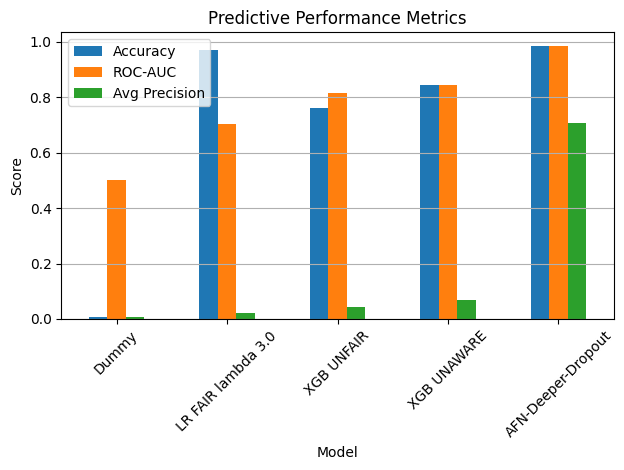

<Figure size 1000x600 with 0 Axes>

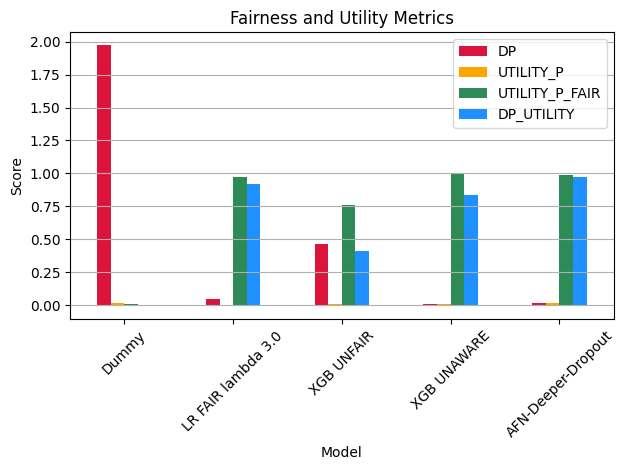

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(models)
df.set_index("Model", inplace=True)

# --- Plot 1: Predictive Performance Metrics ---
plt.figure(figsize=(10, 6))
df[["Accuracy", "ROC-AUC", "Avg Precision"]].plot.bar()
plt.title("Predictive Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("predictive_performance.png")
plt.show()

# --- Plot 2: Fairness and Utility Metrics ---
plt.figure(figsize=(10, 6))
df[["DP", "UTILITY_P", "UTILITY_P_FAIR", "DP_UTILITY"]].plot.bar(color=["crimson", "orange", "seagreen", "dodgerblue"])
plt.title("Fairness and Utility Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("fairness_utility.png")
plt.show()